# Notebook 3 : Content-Based Filtering

## Objectifs de ce notebook

Dans ce notebook, nous allons :

1. Comprendre le concept du Content-Based Filtering
2. Analyser les métadonnées des films (genres, titres)
3. Utiliser TF-IDF pour vectoriser les genres
4. Calculer la similarité cosine entre films
5. Générer des recommandations basées sur le contenu
6. Comparer avec le Collaborative Filtering

---

## Qu'est-ce que le Content-Based Filtering ?

Le Content-Based Filtering recommande des items similaires basés sur leurs caractéristiques (contenu).

### Différence avec Collaborative Filtering :

- **Collaborative** : "Les utilisateurs qui aiment A aiment aussi B"
- **Content-Based** : "Si tu aimes A, voici des films avec des caractéristiques similaires"

### Avantages :

- Pas besoin de données sur d'autres utilisateurs
- Fonctionne bien pour les nouveaux films (pas de cold start pour les items)
- Explications transparentes (on sait pourquoi on recommande)

### Inconvénients :

- Reste dans la zone de confort de l'utilisateur
- Pas de découverte de nouveaux genres
- Besoin de bonnes métadonnées

---

In [1]:
# Librairies pour manipulation de données
import pandas as pd
import numpy as np

# Librairies pour visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Librairies pour le NLP et similarité
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Configuration des graphiques
plt.style.use('ggplot')
sns.set_palette('husl')
%matplotlib inline

# Affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("Librairies importées avec succès")

Librairies importées avec succès


## 2. Chargement des Données

Nous chargeons les données nettoyées du Notebook 1.

Pour le Content-Based Filtering, nous avons besoin :
- Des informations sur les films (titres, genres, année)
- Des ratings pour évaluer les recommandations

In [2]:
movies = pd.read_csv("../data/processed/movies_clean.csv")
ratings = pd.read_csv("../data/processed/ratings_clean.csv")


## on focalisera plus sur movies dataset : 

print(movies.head())

print(f"le Nombre des films sont : {len(movies)}")
print(f'les features sont : {movies.columns.tolist()}')

   item_id              title clean_title    year                     genres  \
0        1   Toy Story (1995)   Toy Story  1995.0  Animation|Children|Comedy   
1        2   GoldenEye (1995)   GoldenEye  1995.0  Action|Adventure|Thriller   
2        3  Four Rooms (1995)  Four Rooms  1995.0                   Thriller   
3        4  Get Shorty (1995)  Get Shorty  1995.0        Action|Comedy|Drama   
4        5     Copycat (1995)     Copycat  1995.0       Crime|Drama|Thriller   

   unknown  Action  Adventure  Animation  Children  Comedy  Crime  \
0        0       0          0          1         1       1      0   
1        0       1          1          0         0       0      0   
2        0       0          0          0         0       0      0   
3        0       1          0          0         0       1      0   
4        0       0          0          0         0       0      1   

   Documentary  Drama  Fantasy  Film-Noir  Horror  Musical  Mystery  Romance  \
0            0      0   

In [3]:
## Exemples des genres
print(movies[['item_id' , 'title' , 'genres']].head(10))

## Vérifier s'il y a des exemples manquantes :

print(f"Valeur manqaunte dans les genres : {movies['genres'].isna().sum()}")

   item_id                                              title  \
0        1                                   Toy Story (1995)   
1        2                                   GoldenEye (1995)   
2        3                                  Four Rooms (1995)   
3        4                                  Get Shorty (1995)   
4        5                                     Copycat (1995)   
5        6  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
6        7                              Twelve Monkeys (1995)   
7        8                                        Babe (1995)   
8        9                            Dead Man Walking (1995)   
9       10                                 Richard III (1995)   

                      genres  
0  Animation|Children|Comedy  
1  Action|Adventure|Thriller  
2                   Thriller  
3        Action|Comedy|Drama  
4       Crime|Drama|Thriller  
5                      Drama  
6               Drama|Sci-Fi  
7      Children|Comedy|Drama  
8    

## 3. Vectorisation des Genres avec TF-IDF

### Qu'est-ce que TF-IDF ?

TF-IDF (Term Frequency - Inverse Document Frequency) transforme du texte en vecteurs numériques.

### Comment ça marche ?

1. **TF (Term Frequency)** : Combien de fois un mot apparaît dans un document
2. **IDF (Inverse Document Frequency)** : Donne moins de poids aux mots très communs

### Exemple pour les genres :

Film 1 : "Action Comedy"
Film 2 : "Action Drama"
Film 3 : "Comedy Romance"

TF-IDF va créer un vecteur pour chaque film basé sur ses genres.
Les films avec des genres similaires auront des vecteurs similaires.

In [4]:
tfidf = TfidfVectorizer(
    token_pattern=r'[A-Za-z]+',
    lowercase=True
)

tfidf_matrix = tfidf.fit_transform(movies['genres'])

## Sur la matrice de tf-idf on s'interesse principalement à : la taille , les lignes (dans notre cas c'est les films ) , les colonnes (genres)

print(f'dimension de la matrice : {tfidf_matrix.shape}')
print(f'Nombre de films : {tfidf_matrix.shape[0]}')
print(f'Nombre de genres uniques : {tfidf_matrix.shape[1]}')


dimension de la matrice : (1682, 21)
Nombre de films : 1682
Nombre de genres uniques : 21


In [5]:
# Voir tous les genres identifiés par TF-IDF
feature_names = tfidf.get_feature_names_out()

print(f"Genres identifiés ({len(feature_names)}) :")
print(feature_names)

Genres identifiés (21) :
['action' 'adventure' 'animation' 'children' 'comedy' 'crime'
 'documentary' 'drama' 'fantasy' 'fi' 'film' 'horror' 'musical' 'mystery'
 'noir' 'romance' 'sci' 'thriller' 'unknown' 'war' 'western']


In [6]:

film_index = 0
film_title = movies.iloc[film_index]['title']
film_genres = movies.iloc[film_index]['genres']

print(f'Film : {film_title}')
print(f'Genres : {film_genres}')

film_vector = tfidf_matrix[film_index].toarray()[0]

for i , value in enumerate(film_vector) :
    if value > 0:
        print(f"  {feature_names[i]} : {value:.4f}")

Film : Toy Story (1995)
Genres : Animation|Children|Comedy
  animation : 0.7407
  children : 0.5739
  comedy : 0.3494


## 4. Calcul de la Similarité Cosine

### Qu'est-ce que la similarité cosine ?

La similarité cosine mesure l'angle entre deux vecteurs.
- Valeur de 0 : Films totalement différents
- Valeur de 1 : Films identiques
- Plus la valeur est proche de 1, plus les films sont similaires

### Comment ça marche ?

On compare les vecteurs TF-IDF de tous les films entre eux.
Cela crée une matrice de similarité : chaque case (i,j) indique la similarité entre le film i et le film j.

In [7]:
# Calculer la similarité cosine entre tous les films
print("Calcul de la matrice de similarité...")
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

print(f"Dimensions de la matrice de similarité : {cosine_sim.shape}")
print(f"Chaque film est comparé avec tous les autres films")

Calcul de la matrice de similarité...
Dimensions de la matrice de similarité : (1682, 1682)
Chaque film est comparé avec tous les autres films


C:\Users\user\AppData\Local\Temp\ipykernel_8752\267311683.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


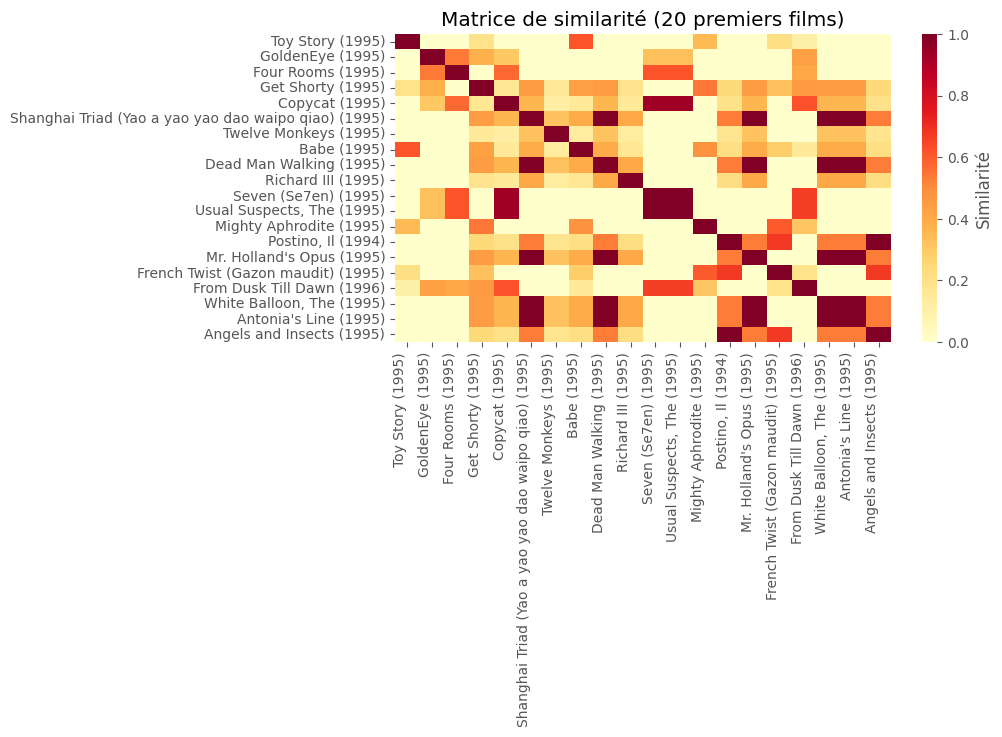

In [8]:
plt.figure(figsize=(8,4))
sns.heatmap(
    data = cosine_sim[:20 , :20],
    cmap = 'YlOrRd',
    xticklabels=movies['title'][:20],
    yticklabels=movies['title'][:20],
    cbar_kws={'label': 'Similarité'}
)
plt.title("Matrice de similarité (20 premiers films)")
plt.xticks(rotation=90, ha='right')
plt.yticks()
plt.tight_layout()
plt.show()

In [19]:
# Prendre Toy Story comme exemple
film_index = 0
film_title = movies.iloc[film_index]['title']

# Récupérer les similarités avec tous les autres films
similarities = cosine_sim[film_index]

# Créer un DataFrame pour mieux voir
sim_df = pd.DataFrame({
    'title': movies['title'],
    'genres': movies['genres'],
    'similarity': similarities
}).sort_values('similarity', ascending=False)

print(f"Films les plus similaires à '{film_title}' :\n")
sim_df.head(10)

Films les plus similaires à 'Toy Story (1995)' :



,title,genres,similarity
0,Toy Story (1995),Animation|Children|Comedy,1.000000
421,Aladdin and the King of Thieves (1996),Animation|Children|Comedy,1.000000
945,"Fox and the Hound, The (1981)",Animation|Children,0.936967
1469,Gumby: The Movie (1995),Animation|Children,0.936967
1411,Land Before Time III: The Time of the Great Gi...,Animation|Children,0.936967
1408,"Swan Princess, The (1994)",Animation|Children,0.936967
624,"Sword in the Stone, The (1963)",Animation|Children,0.936967
1077,Oliver & Company (1988),Animation|Children,0.936967
1065,Balto (1995),Animation|Children,0.936967
101,"Aristocats, The (1970)",Animation|Children,0.936967


In [38]:
def get_content_based_recommendations(film_title, cosine_sim, movies_df = movies, n=10):
    """
    Recommande des films similaires basés sur le contenu
    
    Paramètres :
    - film_title : titre du film
    - cosine_sim : matrice de similarité
    - movies_df : DataFrame des films
    - n : nombre de recommandations
    
    Retourne : DataFrame avec les films similaires
    """
    
    film_idx = movies_df[movies_df['title'] == film_title].index[0]
    film_sim = cosine_sim[film_idx]
    
    
    #### Cette démarche est sans dataframe (comme on a vu avant) , c'est avec python pure :
    
    sim_scores = list(enumerate(cosine_sim[film_idx]))
    sim_scores = sorted(sim_scores , key= lambda x : x[1] , reverse= True)
    
    sim_scores = sim_scores[1:n+1]
    
    film_indices = [i[0] for i in sim_scores]
    similarity_values = [i[1] for i in sim_scores]
    
    recommendations = movies_df.iloc[film_indices][['title' , 'year' , 'genres']].copy()
    recommendations['similarity_score'] = similarity_values
    
    return recommendations
   
    

In [39]:
# Tester avec Toy Story
film_test = "Toy Story (1995)"

print(f"Recommandations basées sur : {film_test}\n")
recommendations = get_content_based_recommendations(film_test, cosine_sim, movies, n=10)
(recommendations)

Recommandations basées sur : Toy Story (1995)



,title,year,genres,similarity_score
421,Aladdin and the King of Thieves (1996),1996.0,Animation|Children|Comedy,1.000000
101,"Aristocats, The (1970)",1970.0,Animation|Children,0.936967
403,Pinocchio (1940),1940.0,Animation|Children,0.936967
624,"Sword in the Stone, The (1963)",1963.0,Animation|Children,0.936967
945,"Fox and the Hound, The (1981)",1981.0,Animation|Children,0.936967
968,Winnie the Pooh and the Blustery Day (1968),1968.0,Animation|Children,0.936967
1065,Balto (1995),1995.0,Animation|Children,0.936967
1077,Oliver & Company (1988),1988.0,Animation|Children,0.936967
1408,"Swan Princess, The (1994)",1994.0,Animation|Children,0.936967
1411,Land Before Time III: The Time of the Great Gi...,1995.0,Animation|Children,0.936967


In [40]:
# Tester avec différents types de films
test_films = [
    "Star Wars (1977)",
    "Titanic (1997)",
    "Pulp Fiction (1994)"
]

for film in test_films:
    print(f"\n{'='*70}")
    print(f"Recommandations pour : {film}")
    print(f"{'='*70}\n")
    
    recs = get_content_based_recommendations(film, cosine_sim, movies, n=5)
    if recs is not None:
        print(recs[['title', 'genres', 'similarity_score']])


Recommandations pour : Star Wars (1977)

                               title  \
180        Return of the Jedi (1983)   
171  Empire Strikes Back, The (1980)   
270         Starship Troopers (1997)   
120    Independence Day (ID4) (1996)   
234             Mars Attacks! (1996)   

                                        genres  similarity_score  
180        Action|Adventure|Romance|Sci-Fi|War          1.000000  
171  Action|Adventure|Drama|Romance|Sci-Fi|War          0.978268  
270                Action|Adventure|Sci-Fi|War          0.941994  
120                          Action|Sci-Fi|War          0.850581  
234                   Action|Comedy|Sci-Fi|War          0.815144  

Recommandations pour : Titanic (1997)

                                 title                          genres  \
312                     Titanic (1997)            Action|Drama|Romance   
1482  Man in the Iron Mask, The (1998)            Action|Drama|Romance   
160                     Top Gun (1986)               

## 6. Recommandations Basées sur l'Historique d'un Utilisateur

Maintenant, au lieu de recommander des films similaires à UN seul film, on va :

1. Prendre tous les films qu'un utilisateur a aimés (note >= 4)
2. Trouver des films similaires à chacun de ces films
3. Agréger les scores pour avoir les meilleures recommandations globales

C'est plus proche d'un vrai système de recommandation.

In [102]:
def get_user_content_recommendations(user_id, ratings_df, movies_df, cosine_sim, n=10, min_rating=4):
    """
    Recommande des films à un utilisateur basé sur son historique
    
    Paramètres :
    - user_id : ID de l'utilisateur
    - ratings_df : DataFrame des ratings
    - movies_df : DataFrame des films
    - cosine_sim : matrice de similarité
    - n : nombre de recommandations
    - min_rating : note minimum pour considérer qu'il a aimé
    
    Retourne : DataFrame avec les recommandations
    """
    
    # Récupérer les films que l'utilisateur a aimés
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    liked_films = user_ratings[user_ratings['rating'] >= min_rating]
    
    print(f"L'utilisateur {user_id} a aimé {len(liked_films)} films (note >= {min_rating})")
    
    # Films déjà vus par l'utilisateur
    seen_items = user_ratings['item_id'].tolist()
    
    # Dictionnaire pour accumuler les scores
    recommendation_scores = {}
    
    # Pour chaque film aimé
    for _, row in liked_films.iterrows():
        item_id = row['item_id']
        idx = movies_df[movies_df['item_id'] == item_id].index[0]
        
        # Récupérer les similarités
        sim_scores = list(enumerate(cosine_sim[idx]))
        
        # Pour chaque film similaire
        for film_idx, sim_score in sim_scores:
            film_id = movies_df.iloc[film_idx]['item_id']
            
            # Ne pas recommander des films déjà vus
            if film_id not in seen_items:
                if film_id not in recommendation_scores:
                    recommendation_scores[film_id] = 0
                # Accumuler le score de similarité
                recommendation_scores[film_id] += sim_score
    
    # Trier par score décroissant
    sorted_recommendations = sorted(recommendation_scores.items(), key=lambda x: x[1], reverse=True)
    
    # Prendre les top N
    top_items = sorted_recommendations[:n]
    top_ids = [item[0] for item in top_items]
    top_scores = [item[1] for item in top_items]
    
    # Créer le DataFrame de recommandations
    recommendations = movies_df[movies_df['item_id'].isin(top_ids)][['item_id', 'title', 'year', 'genres']].copy()
    
    # Ajouter les scores
    score_dict = dict(zip(top_ids, top_scores))
    recommendations['content_score'] = recommendations['item_id'].map(score_dict)
    recommendations = recommendations.sort_values('content_score', ascending=False)
    
    return recommendations

print("Fonction de recommandation utilisateur créée (version corrigée)")

Fonction de recommandation utilisateur créée (version corrigée)


In [103]:
# Tester avec l'utilisateur 196 (le même qu'au Notebook 2)
user_id = 196

# Voir d'abord ce qu'il a aimé
user_history = ratings[ratings['user_id'] == user_id].merge(
    movies[['item_id', 'title', 'genres']], 
    on='item_id'
).sort_values('rating', ascending=False)

print(f"Films aimés par l'utilisateur {user_id} (note >= 4) :\n")
print(user_history[user_history['rating'] >= 4][['title', 'rating', 'genres']].head(10))

Films aimés par l'utilisateur 196 (note >= 4) :

                                title  rating                         genres
27              Secrets & Lies (1996)       5                          Drama
14     American President, The (1995)       5           Comedy|Drama|Romance
4                  Stand by Me (1986)       5         Adventure|Comedy|Drama
5   Ace Ventura: Pet Detective (1994)       5                         Comedy
31        Fish Called Wanda, A (1988)       5                         Comedy
8                  Being There (1979)       5                         Comedy
12        English Patient, The (1996)       5              Drama|Romance|War
15                        Babe (1995)       5          Children|Comedy|Drama
29         Waiting for Guffman (1996)       4                         Comedy
30        Nutty Professor, The (1996)       4  Comedy|Fantasy|Romance|Sci-Fi


In [104]:
# Générer les recommandations content-based
print(f"\n{'='*70}")
print("Recommandations Content-Based")
print(f"{'='*70}\n")

content_recommendations = get_user_content_recommendations(
    user_id=user_id,
    ratings_df=ratings,
    movies_df=movies,
    cosine_sim=cosine_sim,
    n=10,
    min_rating=4
)

print("\nTop 10 recommandations :\n")
print(content_recommendations[['title', 'year', 'genres', 'content_score']])


Recommandations Content-Based

L'utilisateur 196 a aimé 22 films (note >= 4)

Top 10 recommandations :

                                                 title    year  genres  \
25                       Brothers McMullen, The (1995)  1995.0  Comedy   
39   To Wong Foo, Thanks for Everything! Julie Newm...  1995.0  Comedy   
40                                Billy Madison (1995)  1995.0  Comedy   
41                                       Clerks (1994)  1994.0  Comedy   
84                                     Ref, The (1994)  1994.0  Comedy   
103                                Theodore Rex (1995)  1995.0  Comedy   
104                                  Sgt. Bilko (1996)  1996.0  Comedy   
121                              Cable Guy, The (1996)  1996.0  Comedy   
153                Monty Python's Life of Brian (1979)  1979.0  Comedy   
157                         Weekend at Bernie's (1989)  1989.0  Comedy   

     content_score  
25       14.735632  
39       14.735632  
40       14.73563

## 7. Comparaison : Collaborative vs Content-Based

Comparons les recommandations des deux approches pour le même utilisateur.

### Rappel des différences :

- **Collaborative Filtering** (Notebook 2) : Basé sur les comportements similaires des utilisateurs
- **Content-Based Filtering** (Notebook 3) : Basé sur les caractéristiques des films (genres)

Nous allons charger le modèle SVD du Notebook 2 et comparer les résultats.

In [87]:
import pickle

with open('../models/svd_model.pkl' , 'rb') as f:
    svd_model = pickle.load(f)
    
print("Modèle SVD chargé avec succès")

Modèle SVD chargé avec succès


In [105]:
def get_svd_recommendations(algo, user_id, ratings_df, movies_df, n=10):
    """
    Génère les recommandations avec le modèle SVD (Collaborative Filtering)
    """
    
    user_ratings = ratings_df[ratings_df['user_id'] == user_id]
    noted_items = user_ratings['item_id'].tolist()
    
    all_items = movies_df['item_id'].tolist()
    
    items_to_predict = [item for item in all_items if item not in noted_items]
    
    predictions = []
    
    for item_id in items_to_predict:
        
        predictions.append(
            {
                'item_id' : item_id,
                'svd_score' : algo.predict(user_id , item_id).est
            }
        )
        
    predictions_df = pd.DataFrame(predictions)
    predictions_df = predictions_df.sort_values('svd_score', ascending=False).head(n)
    recommendations = predictions_df.merge(movies[['item_id' , 'title', 'year' , 'genres']] , on = 'item_id')
    
    return recommendations
    

In [106]:
if svd_model is not None:
    # Utilisateur test
    user_id = 196
    
    # Recommandations Collaborative (SVD)
    svd_recs = get_svd_recommendations(svd_model, user_id, ratings, movies, n=10)
    
    # Recommandations Content-Based
    content_recs = get_user_content_recommendations(
        user_id, ratings, movies, cosine_sim, n=10, min_rating=4
    )
    
    print(f"\n{'='*70}")
    print(f"UTILISATEUR {user_id} - COMPARAISON DES APPROCHES")
    print(f"{'='*70}\n")
    
    print("COLLABORATIVE FILTERING (SVD) :")
    print(svd_recs[['title', 'year', 'genres', 'svd_score']])
    
    print(f"\n{'='*70}\n")
    
    print("CONTENT-BASED FILTERING :")
    print(content_recs[['title', 'year', 'genres', 'content_score']])

L'utilisateur 196 a aimé 22 films (note >= 4)

UTILISATEUR 196 - COMPARAISON DES APPROCHES

COLLABORATIVE FILTERING (SVD) :
                                      title    year  \
0                 Leave It to Beaver (1997)  1997.0   
1              Devil in a Blue Dress (1995)  1995.0   
2  Treasure of the Sierra Madre, The (1948)  1948.0   
3          Streetcar Named Desire, A (1951)  1951.0   
4                            Matilda (1996)  1996.0   
5    One Flew Over the Cuckoo's Nest (1975)  1975.0   
6                             Vermin (1998)  1998.0   
7                           Net, The (1995)  1995.0   
8              To Kill a Mockingbird (1962)  1962.0   
9                Murder in the First (1995)  1995.0   

                             genres  svd_score  
0                            Comedy   5.000000  
1  Crime|Film-Noir|Mystery|Thriller   5.000000  
2                         Adventure   5.000000  
3                             Drama   5.000000  
4                   Child

In [107]:
if svd_model is not None:
    # Films recommandés par les deux approches
    svd_titles = set(svd_recs['title'].tolist())
    content_titles = set(content_recs['title'].tolist())
    
    # Intersection (films communs)
    common = svd_titles.intersection(content_titles)
    
    # Films uniques à chaque approche
    only_svd = svd_titles - content_titles
    only_content = content_titles - svd_titles
    
    print("\nANALYSE DES DIFFÉRENCES :\n")
    print(f"Films recommandés par les DEUX approches : {len(common)}")
    if len(common) > 0:
        print(f"  → {list(common)}")
    
    print(f"\nFilms uniquement par COLLABORATIVE : {len(only_svd)}")
    if len(only_svd) > 0:
        for title in list(only_svd)[:3]:
            print(f"  → {title}")
    
    print(f"\nFilms uniquement par CONTENT-BASED : {len(only_content)}")
    if len(only_content) > 0:
        for title in list(only_content)[:3]:
            print(f"  → {title}")
    
    print("\nOBSERVATIONS :")
    print("- Collaborative : Découvre des films que d'autres utilisateurs similaires ont aimés")
    print("- Content-Based : Reste proche des genres déjà aimés par l'utilisateur")


ANALYSE DES DIFFÉRENCES :

Films recommandés par les DEUX approches : 0

Films uniquement par COLLABORATIVE : 10
  → Leave It to Beaver (1997)
  → Vermin (1998)
  → To Kill a Mockingbird (1962)

Films uniquement par CONTENT-BASED : 10
  → Theodore Rex (1995)
  → Billy Madison (1995)
  → Clerks (1994)

OBSERVATIONS :
- Collaborative : Découvre des films que d'autres utilisateurs similaires ont aimés
- Content-Based : Reste proche des genres déjà aimés par l'utilisateur


## 8. Sauvegarde de la Matrice de Similarité

Nous sauvegardons la matrice de similarité et le vectoriseur TF-IDF pour les utiliser dans le Notebook 4 (Hybrid Model).

In [108]:
import pickle
import os

# Créer le dossier models s'il n'existe pas
os.makedirs('../models', exist_ok=True)

# Sauvegarder la matrice de similarité
with open('../models/cosine_sim_matrix.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Sauvegarder le vectoriseur TF-IDF
with open('../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

print("Sauvegarde terminée")
print("- cosine_sim_matrix.pkl : Matrice de similarité")
print("- tfidf_vectorizer.pkl : Vectoriseur TF-IDF")

Sauvegarde terminée
- cosine_sim_matrix.pkl : Matrice de similarité
- tfidf_vectorizer.pkl : Vectoriseur TF-IDF


## Résumé du Notebook 3

### Ce qu'on a appris :

1. **TF-IDF** : Transforme les genres en vecteurs numériques
2. **Similarité Cosine** : Mesure la similarité entre films basée sur leurs genres
3. **Content-Based Filtering** : Recommande des films similaires en contenu

### Résultats obtenus :

- Matrice TF-IDF : 1682 films × 21 genres
- Matrice de similarité : 1682 × 1682
- Recommandations basées uniquement sur les métadonnées des films

### Avantages du Content-Based :

- Pas de cold start pour les nouveaux films
- Explications transparentes (on sait pourquoi on recommande)
- Fonctionne même avec peu de données utilisateurs

### Inconvénients :

- Reste dans la zone de confort (mêmes genres)
- Pas de découverte de nouveaux types de films
- Dépend de la qualité des métadonnées

### Comparaison avec Collaborative :

- **Collaborative** : Découvre des films différents basés sur d'autres utilisateurs
- **Content-Based** : Reste proche des préférences actuelles de l'utilisateur
- Aucun film en commun dans le top 10 pour notre utilisateur test

### Prochaine étape :

Dans le Notebook 4, nous allons **combiner** les deux approches (Hybrid Model) pour avoir le meilleur des deux mondes.